In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
datasetdir = '/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/images_scaled'
os.chdir(datasetdir)

In [4]:
# Load file locations
df_info = pd.read_excel('/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/dataset_information.xlsx', sheet_name = 'images.txt')

#Load class information
df_classes = pd.read_excel('/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/dataset_information.xlsx', sheet_name = 'classes.txt')

In [5]:
#Split the class and image name
df_image = df_info.join(df_info['image_location'].str.split('/',expand=True).rename(columns={0:'class_id',1:'image_name'})) 

In [6]:
#Convert the string column to INT to chop leading zeroes
df_image['class_id'] = df_image['class_id'].astype(int)

In [7]:
#Join the information and class dataframe 
df_bird = pd.merge(df_image, df_classes, left_on='class_id', right_on='child_class_id', how='left').drop('child_class_id', axis=1)

In [8]:
#Find the count of bird class in case only specific classes need to be to the model
DF_classcounts = df_bird.groupby(['class_id'])['class_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 

In [9]:
DF_classcounts['count'].values

array([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
       119, 119, 119, 119, 119, 119, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 118, 117, 117, 117, 117, 117, 117,
       117, 117, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
       116, 116, 116, 116, 115, 115, 115, 115, 114, 114, 114, 114, 113,
       113, 113, 113, 113, 113, 113, 113, 113, 112, 112, 112, 112, 112,
       111, 111, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 108, 10

In [13]:
DF_classcounts[DF_classcounts['count'] >= 100].sum()

class_id    163567
count        26390
dtype: int64

In [14]:
len(DF_classcounts[DF_classcounts['count'] >= 100].values)

231

In [15]:
DF_classcounts[DF_classcounts['count'] >= 100].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 523 to 488
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   class_id  231 non-null    int64
 1   count     231 non-null    int64
dtypes: int64(2)
memory usage: 5.4 KB


## **Target Variables here: all classes with (Number of images) >= 100. Total 231 classes with 26390 images.**

In [16]:
#Selected only specific labels
target_class = DF_classcounts[(DF_classcounts['count'] >= 100)]['class_id'].values

df_bird['FILTERED_LABEL'] = (df_bird.class_id.isin(target_class)).astype('int')

In [17]:
DF_classcounts[(DF_classcounts['count'] >= 100)]['count'].sum()

26390

In [18]:
len(target_class)

231

In [19]:
df_target =  df_bird[df_bird['FILTERED_LABEL']==1]

In [20]:
len(df_target)

26390

In [21]:
# Move 'class_id' and 'image_location' into string type features 
df_target['class_id'] = df_target['class_id'].astype(str)
df_target['image_location'] = df_target['image_location'].astype(str)

In [22]:
datasetdir = '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled'
os.chdir(datasetdir)

**Split the data into train set 60%, validation set 15% and a test set 25%.**

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df_target['image_location'], df_target['class_id'], test_size=0.25, random_state=44)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/5, train_size=4/5, random_state=44)

print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))
print("Number of posters for training: ", len(X_test))

Number of posters for training:  15833
Number of posters for validation:  3959
Number of posters for training:  6598


In [84]:
15833 + 3959 + 6598

26390

In [85]:
len(X_train)/len(df_target)

0.5999621068586586

In [86]:
len(X_val)/len(df_target)

0.15001894657067072

In [87]:
len(X_test)/len(df_target)

0.2500189465706707

In [88]:
X_train = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_val = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_val]
#X_test = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_train[:5]

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0549/fc86370d597f4dbfafd2cc7e14b60389.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0529/b58acce59b3c4823834cc90438926d64.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0513/208f71b90181475c942dbb826bc3bb3e.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0903/59defeb898bd4570a2f89bd189e68ef4.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0508/bf22a63dea2b4c95b00015ba05a19fc7.jpg']

In [66]:
X_train[1]

'/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0529/b58acce59b3c4823834cc90438926d64.jpg'

**For simplicity, let's encode our target labels into one-hot encoded labels using preprocessing.LabelBinarizer().**

In [90]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
lb.fit(y_val)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [91]:
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)
y_test_bin = lb.transform(y_test)

**Model MobileNet_v2 requires our images to have shape of (224, 224, 3).**

In [92]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
N_CLASSES = len(lb.classes_)

**Create a function that normalize and resize images inputs to the fixed shape required by the model.**

In [93]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    #path = '../images_scaled/'+filename
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [94]:
BATCH_SIZE = 512 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 512 # Shuffle the training data by a chunck of 512 observations

In [95]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    print(filenames)
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [96]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)
test_ds = create_dataset(X_test, y_test_bin)

Output hidden; open in https://colab.research.google.com to view.

In [97]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (512, 224, 224, 3)
Shape of labels array: (512, 231)


In [98]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

**In this exercise, let's start only changing the last Dense FC layers of the model "mobilenet_v2_100_224".**

In [99]:
feature_extractor_layer.trainable = False

In [100]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layer2'),
    layers.Dense(N_CLASSES, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               524800    
_________________________________________________________________
output (Dense)               (None, 231)               118503    
Total params: 4,213,031
Trainable params: 1,955,047
Non-trainable params: 2,257,984
_________________________________________________________________


In [101]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [102]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy'])
    
history = model.fit(train_ds, epochs=40,batch_size = 16,
                            validation_data=create_dataset(X_val, y_val_bin))


['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0657/e984020af43e4c0691f2bbfb9c2ac1a7.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0926/e8906b7aca22496baf40d9b2fa42d4bd.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0332/6663f04d6d534836b4a9ba33bb1a236d.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0503/f1dea835c53340b4b8c1944b66300495.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0469/a01c76b421e74857830af668d517e4c5.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0913/861bb9a95983484f8b62a54bb3479a04.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0914/9975f71e9ce8478fb145511ec0c868d8.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/i

In [ ]:
def eval_model(model, X_test, Y_test):
    # TODO: evaluate the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    test_loss, test_accuracy = model.evaluate(X_test, Y_test)


    return test_loss, test_accuracy

In [126]:
test_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 231)), types: (tf.float32, tf.int64)>

In [131]:
Result = model.evaluate(test_ds)

13/13 [==============================] - 3s 215ms/step - loss: 0.0102 - macro_f1: 0.4269 - accuracy: 0.6065


### **Plot macro_f1 from the training and validation steps**

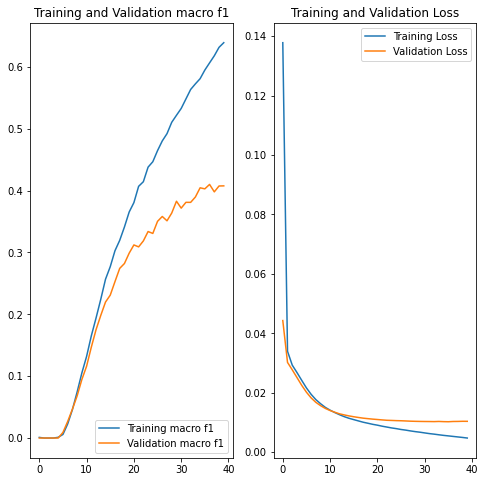

In [103]:
mf1 = history.history['macro_f1']
val_mf1 = history.history['val_macro_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Plot accuracy from the training and validation steps**

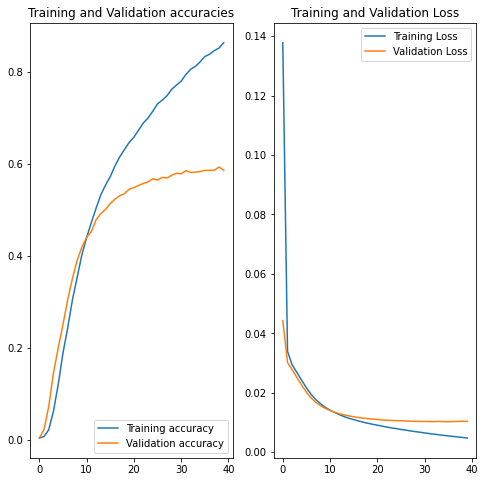

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [107]:
def show_prediction(model, img_path, df_target):

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    print(prediction)
    prediction = pd.Series(prediction[0])
    prediction.index = lb.classes_
    prediction = prediction[prediction==1].index.values
    print(prediction)

    class_description ="Not Found"

    #Get the class description of the bird
    if prediction[0] != "" :
      class_description = df_target.loc[df_target['class_id']== prediction[0]]['class_description'].iloc[0]
    else:
      prediction = "Not Found"


    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\nPrediction\n{}\n'.format(list(prediction)), fontsize=9)
    plt.title('\nBird class\n{}\n'.format(class_description), fontsize=9)
    plt.show()

# **Testing our model**

In [132]:
Result = model.evaluate(test_ds)

13/13 [==============================] - 3s 215ms/step - loss: 0.0102 - macro_f1: 0.4212 - accuracy: 0.6065


In [118]:
type(test_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

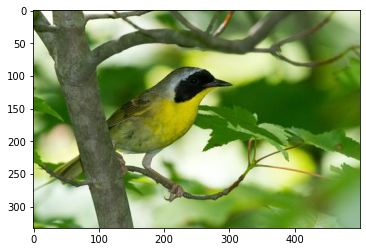

In [ ]:
img_path='/content/a8246880fb5143bbb25d905e6e0d7880.jpg'
plt.imshow(Image.open(img_path))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
['756']


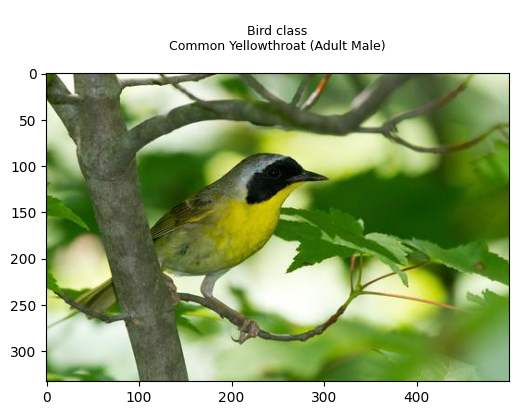

In [ ]:
show_prediction(model,img_path, df_target )

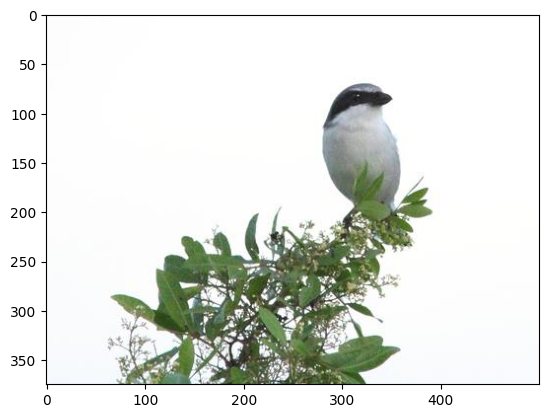

In [ ]:
img_path2='/content/433f9ebea944418caf1d96884bce2db9.jpg'
plt.imshow(Image.open(img_path2))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
['937']


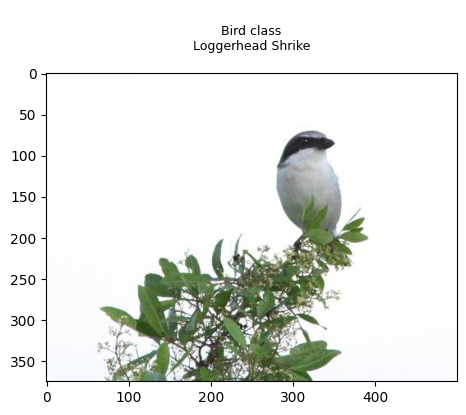

In [ ]:
show_prediction(model,img_path2, df_target )

In [ ]:
DF_classcounts[(DF_classcounts['count']>=114) & (DF_classcounts['count']<=120)]['class_id'].values

array([ 979,  902,  672,  397,  856,  783,  756,  910,  790,  501,  879,
        504,  794,  885,  511,  512,  852,  363,  851,  987,  543,  777,
        937,  914,  929,  559,  485,  950,  952,  477,  766,  949,  469,
        928,  553,  769,  873,  875,  772,  773,  947,  451,  450,  355,
        657,  352,  819,  883,  529, 1001,  822,  823,  824,  888,  842,
        830,  320,  642,  317,  840,  938,  314,  643,  299,  835,  836,
        881,  483,  900,  989,  935,  655,  521,  522,  700,  848,  864,
        350,  746,  762,  681,  868,  973,  554,  926,  753,  796,  778,
        964,  561,  793,  673,  780,  395,  764,  382,  381,  669,  930,
        958,  357,  560,  857,  499,  616,  912,  811,  446,  884,  354,
        831,  957,  528,  527,  358,  827,  400, 1003,  458,  515,  748,
        509,  747,  760,  866,  908,  470,  903,  963,  315,  850,  802,
        338,  804,  898,  886,  960,  779,  913,  814,  867,  832])

# **Conclusions**: our accuracy and macro f1 still need to be improved in this way, but remember that in this task there were included 231 classes with 26390 images, which is more than one half of the images contained in the whole NABirds dataset. We also used the pretrained MobileNet_v2_100_224 via Transfer Learning.